In [26]:
import pandas as pd
import re
import nltk
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [27]:
# from google.colab import drive
# drive.mount('/content/drive', force_remount=True)

In [28]:
# # Loading the dataset (using the downloaded file)
# path = "/content/drive/MyDrive/Colab Notebooks/DATA255_Assignment/IMDB_Dataset.csv"
# df = pd.read_csv(path)

In [29]:
df= pd.read_csv("IMDB_Dataset.csv")
df.head()

,review,sentiment
0,Once again Mr. Costner has dragged out a movie...,0
1,This is an example of why the majority of acti...,0
2,"First of all I hate those moronic rappers, who...",0
3,Not even the Beatles could write songs everyon...,0
4,Brass pictures (movies is not a fitting word f...,0


In [30]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [31]:
##cleaning up the text
stopWords = set(nltk.corpus.stopwords.words("english"))
def CleanText(text):
    text = text.lower()
    text = re.sub("[^a-z]", " ", text)
    words = [word for word in text.split() if word not in stopWords]
    text = " ".join(words)
    return text

df["review"]=df.apply(lambda row: CleanText(row["review"]), axis=1)
Data = df.review
labels = df.sentiment

In [32]:
### converting 1000 most frequent words to integer
frequentWord = 10000
tokenizer = Tokenizer(num_words=frequentWord)

tokenizer.fit_on_texts(Data)

IntegerizedData = pd.Series(tokenizer.texts_to_sequences(Data))
IntegerizedData.head()

0    [315, 6873, 3237, 2, 117, 996, 1569, 1033, 117...
1    [342, 2080, 100, 30, 3711, 232, 11, 66, 165, 5...
2    [20, 595, 4986, 24, 8579, 369, 844, 7247, 2536...
3    [8, 5767, 24, 749, 582, 180, 304, 147, 2329, 2...
4    [8836, 1155, 25, 3325, 521, 11, 535, 9224, 920...
dtype: object

In [33]:
### You can convert the sequences back to the string
tokenizer.sequences_to_texts(IntegerizedData[0:1])

['mr costner dragged movie far longer necessary aside terrific sea rescue sequences care characters us ghosts closet costner character realized early forgotten much later time care character really care cocky ashton kutcher problem comes kid thinks better anyone else around shows signs closet appears winning costner finally well past half way point stinker costner tells us kutcher ghosts told kutcher driven best prior magic could keep turning hour']

In [34]:
DataLength=IntegerizedData.apply(lambda x: len(x))
DataLength.describe()

count    50000.000000
mean       110.157100
std         81.213625
min          3.000000
25%         60.000000
50%         83.000000
75%        135.000000
max       1104.000000
dtype: float64

The average length of reviews is 110, the shortest review length is 3 and the longest is 1104.

Therefore we need to pad the sequences to equal length.

The following padding function performs zero padding if the length of a sequence is less than the threshold and truncate the ones which are longer than threshold to the threshold.  We choose the threshold to be 256.

In [35]:
#zero padding
IntegerizedData= pad_sequences(IntegerizedData, maxlen=256)


In [36]:
IntegerizedData

array([[   0,    0,    0, ...,  269, 1456,  397],
       [   0,    0,    0, ...,  363,    3,   80],
       [   0,    0,    0, ...,   54,   57,   76],
       ...,
       [   0,    0,    0, ...,  973,   99, 9907],
       [   0,    0,    0, ..., 8508, 3506,   13],
       [   0,    0,    0, ...,   11, 2263,   23]], dtype=int32)

In [37]:
x_train_val,x_test,y_train_val,y_test = train_test_split(IntegerizedData,labels,stratify=labels,test_size=0.20, random_state=42)
x_train,x_val,y_train,y_val = train_test_split(x_train_val,y_train_val,stratify=y_train_val,test_size=0.10, random_state=42)

In [38]:
type(x_val)

numpy.ndarray

In [39]:
print(y_train.shape,y_val.shape,y_test.shape)

(36000,) (4000,) (10000,)


## now you have your training, validation and test set as numpy arrays, you can implement the networks

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
import tensorflow as tf
import torch
from torch.utils.data import TensorDataset, DataLoader
import time

In [41]:
# Define GRU Classifier model
class GRU(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GRU, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.fc(output[:, -1, :])  # Get the output from the last time step
        output = self.sigmoid(output)
        return output.squeeze(1)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Epoch 1/40, Time: 1.75s, Train Loss: 0.5112, Val Loss: 0.4102, Train Accuracy: 0.7348, Val Accuracy: 0.8177
Epoch 2/40, Time: 1.56s, Train Loss: 0.3271, Val Loss: 0.3153, Train Accuracy: 0.8634, Val Accuracy: 0.8712
Epoch 3/40, Time: 1.52s, Train Loss: 0.2551, Val Loss: 0.2928, Train Accuracy: 0.8999, Val Accuracy: 0.8835
Epoch 4/40, Time: 1.55s, Train Loss: 0.2077, Val Loss: 0.3040, Train Accuracy: 0.9227, Val Accuracy: 0.8850
Epoch 5/40, Time: 1.55s, Train Loss: 0.1727, Val Loss: 0.3147, Train Accuracy: 0.9370, Val Accuracy: 0.8880
Epoch 6/40, Time: 1.53s, Train Loss: 0.1375, Val Loss: 0.3482, Train Accuracy: 0.9528, Val Accuracy: 0.8808
Epoch 7/40, Time: 1.52s, Train Loss: 0.1064, Val Loss: 0.3387, Train Accuracy: 0.9647, Val Accuracy: 0.8835
Epoch 8/40, Time: 1.51s, Train Loss: 0.0812, Val Loss: 0.3789, Train Accuracy: 0.9745, Val Accuracy: 0.8745
Epoch 9/40, Time: 1.53s, Train Loss: 0.0603, Val Loss: 0.4421, Train Accuracy: 0.9816, Val Accuracy: 0.8780
Epoch 10/40, Time: 1.52s, Tr

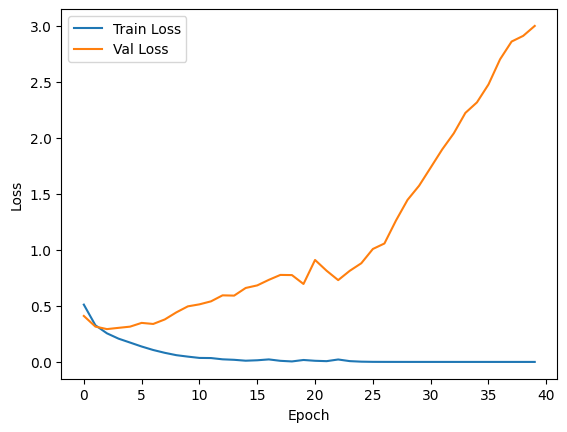

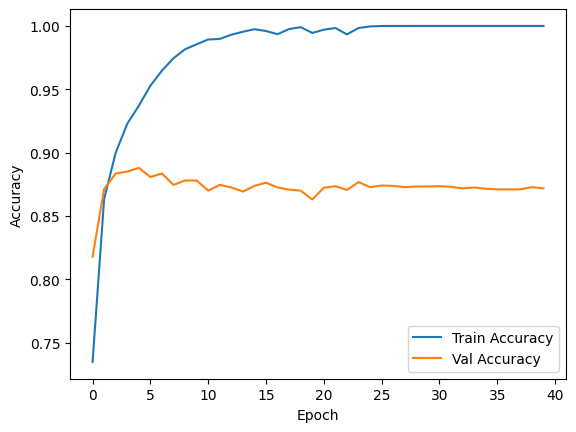

Test Accuracy: 0.8710


In [43]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=64)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.001
num_epochs = 40

# Instantiate the model and move it to GPU
model = GRU(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Changing the batch size to 150 and learning rate to 0.0001

Epoch 1/80, Time: 0.94s, Train Loss: 0.6880, Val Loss: 0.6826, Train Accuracy: 0.5417, Val Accuracy: 0.5667
Epoch 2/80, Time: 0.93s, Train Loss: 0.6721, Val Loss: 0.6632, Train Accuracy: 0.5890, Val Accuracy: 0.6022
Epoch 3/80, Time: 0.95s, Train Loss: 0.6041, Val Loss: 0.5590, Train Accuracy: 0.6706, Val Accuracy: 0.7157
Epoch 4/80, Time: 0.96s, Train Loss: 0.5169, Val Loss: 0.5072, Train Accuracy: 0.7480, Val Accuracy: 0.7475
Epoch 5/80, Time: 0.97s, Train Loss: 0.4682, Val Loss: 0.4670, Train Accuracy: 0.7833, Val Accuracy: 0.7810
Epoch 6/80, Time: 0.94s, Train Loss: 0.4311, Val Loss: 0.4366, Train Accuracy: 0.8084, Val Accuracy: 0.8020
Epoch 7/80, Time: 0.92s, Train Loss: 0.4015, Val Loss: 0.4145, Train Accuracy: 0.8248, Val Accuracy: 0.8167
Epoch 8/80, Time: 0.92s, Train Loss: 0.3773, Val Loss: 0.3995, Train Accuracy: 0.8391, Val Accuracy: 0.8243
Epoch 9/80, Time: 0.92s, Train Loss: 0.3588, Val Loss: 0.3860, Train Accuracy: 0.8488, Val Accuracy: 0.8290
Epoch 10/80, Time: 0.92s, Tr

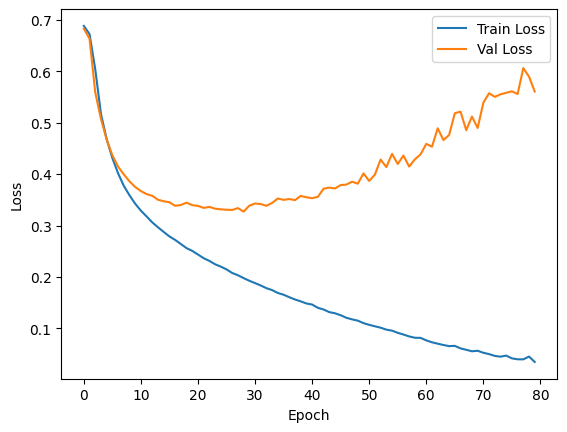

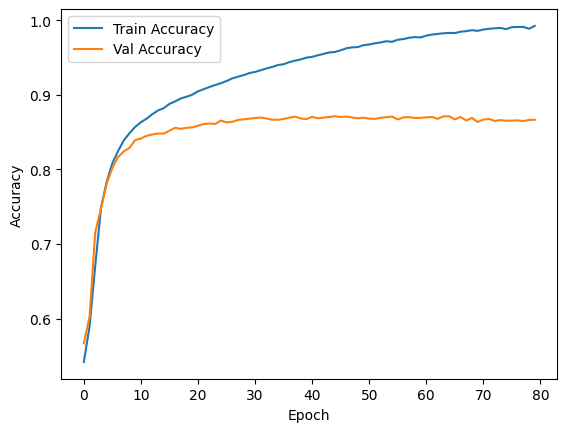

Test Accuracy: 0.8545


In [44]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=150, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=150)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
num_epochs = 80

# Instantiate the model and move it to GPU
model = GRU(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 1e-3

Epoch 1/80, Time: 0.97s, Train Loss: 0.6930, Val Loss: 0.6890, Train Accuracy: 0.5188, Val Accuracy: 0.5320
Epoch 2/80, Time: 0.84s, Train Loss: 0.6850, Val Loss: 0.6831, Train Accuracy: 0.5513, Val Accuracy: 0.5575
Epoch 3/80, Time: 0.79s, Train Loss: 0.6788, Val Loss: 0.6777, Train Accuracy: 0.5719, Val Accuracy: 0.5745
Epoch 4/80, Time: 0.80s, Train Loss: 0.6721, Val Loss: 0.6706, Train Accuracy: 0.5874, Val Accuracy: 0.5917
Epoch 5/80, Time: 1.17s, Train Loss: 0.6618, Val Loss: 0.6556, Train Accuracy: 0.6038, Val Accuracy: 0.6130
Epoch 6/80, Time: 0.74s, Train Loss: 0.6221, Val Loss: 0.5836, Train Accuracy: 0.6489, Val Accuracy: 0.6855
Epoch 7/80, Time: 0.72s, Train Loss: 0.5567, Val Loss: 0.5259, Train Accuracy: 0.7156, Val Accuracy: 0.7458
Epoch 8/80, Time: 0.71s, Train Loss: 0.5054, Val Loss: 0.4869, Train Accuracy: 0.7592, Val Accuracy: 0.7698
Epoch 9/80, Time: 0.75s, Train Loss: 0.4696, Val Loss: 0.4610, Train Accuracy: 0.7831, Val Accuracy: 0.7853
Epoch 10/80, Time: 0.75s, Tr

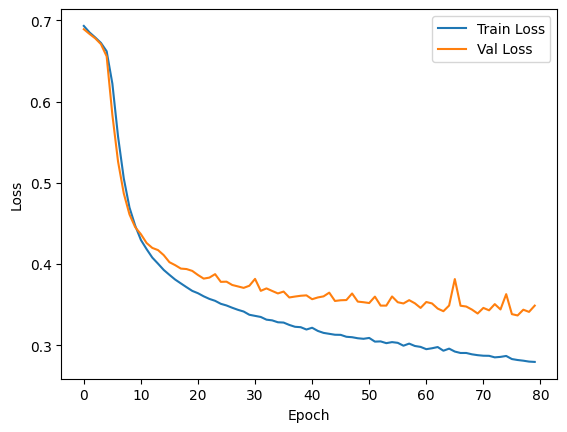

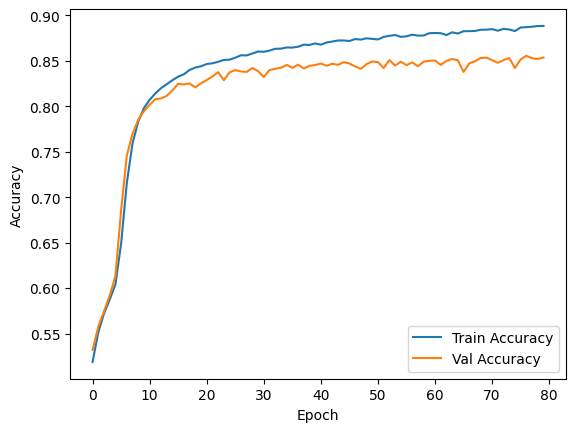

Test Accuracy: 0.8521


In [56]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=300)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
weight_decay = 1e-3  # Weight decay parameter
num_epochs = 80

# Instantiate the model and move it to GPU
model = GRU(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Adding weight decay

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

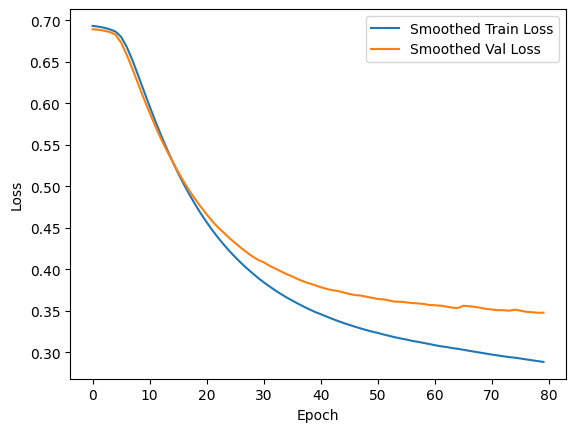

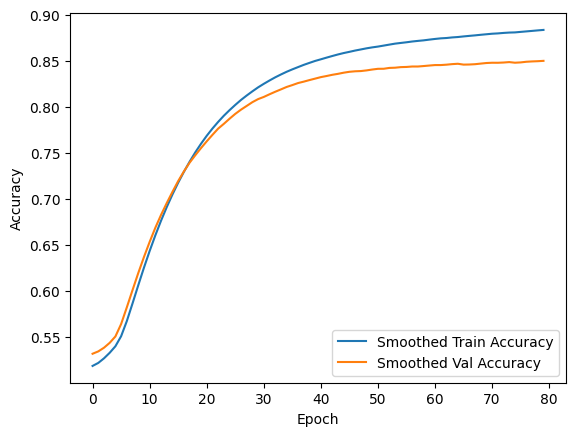

Test Accuracy: 0.8521


In [57]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## Adding dropout with probability of 0.1
# Best Graph
## Hyperparameters
## Dropout = 0.1
## L2 Regularization = 1e-3
## Batch Size = 300
## Learning Rate = 0.0001

In [66]:
import torch
import torch.nn as nn

class GRU_dropout(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(GRU_dropout, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        self.gru = nn.GRU(embedding_dim, hidden_dim, batch_first=True)
        self.dropout = nn.Dropout(0.1)  # Adding dropout layer
        self.fc = nn.Linear(hidden_dim, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        embedded = self.embedding(x)
        output, _ = self.gru(embedded)
        output = self.dropout(output)  # Applying dropout
        output = self.fc(output[:, -1, :])  # Get the output from the last time step
        output = self.sigmoid(output)
        return output.squeeze(1)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


Epoch 1/80, Time: 0.91s, Train Loss: 0.6929, Val Loss: 0.6886, Train Accuracy: 0.5191, Val Accuracy: 0.5475
Epoch 2/80, Time: 0.75s, Train Loss: 0.6878, Val Loss: 0.6852, Train Accuracy: 0.5427, Val Accuracy: 0.5555
Epoch 3/80, Time: 0.75s, Train Loss: 0.6841, Val Loss: 0.6818, Train Accuracy: 0.5585, Val Accuracy: 0.5647
Epoch 4/80, Time: 0.74s, Train Loss: 0.6798, Val Loss: 0.6779, Train Accuracy: 0.5722, Val Accuracy: 0.5690
Epoch 5/80, Time: 0.72s, Train Loss: 0.6748, Val Loss: 0.6720, Train Accuracy: 0.5797, Val Accuracy: 0.5825
Epoch 6/80, Time: 0.74s, Train Loss: 0.6646, Val Loss: 0.6538, Train Accuracy: 0.5991, Val Accuracy: 0.6225
Epoch 7/80, Time: 0.77s, Train Loss: 0.6040, Val Loss: 0.5761, Train Accuracy: 0.6695, Val Accuracy: 0.6970
Epoch 8/80, Time: 0.72s, Train Loss: 0.5396, Val Loss: 0.5297, Train Accuracy: 0.7309, Val Accuracy: 0.7412
Epoch 9/80, Time: 0.71s, Train Loss: 0.5009, Val Loss: 0.4986, Train Accuracy: 0.7620, Val Accuracy: 0.7650
Epoch 10/80, Time: 0.71s, Tr

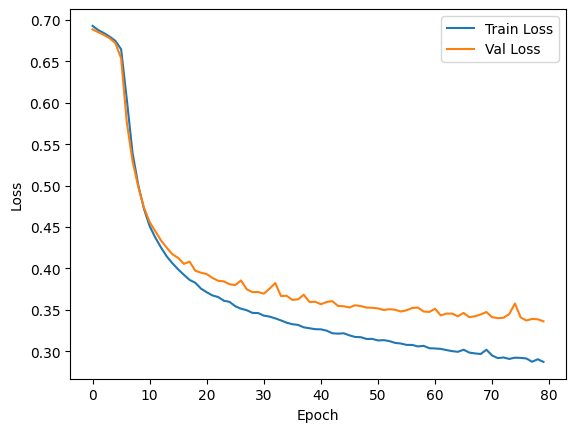

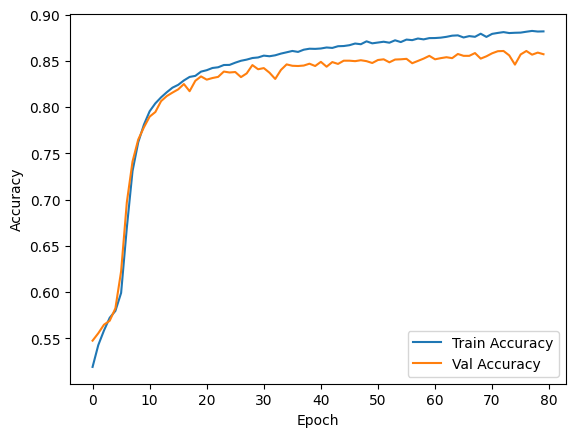

Test Accuracy: 0.8532


In [67]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=300, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=300)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
weight_decay = 1e-3  # Weight decay parameter
num_epochs = 80

# Instantiate the model and move it to GPU
model = GRU_dropout(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Adding weight decay

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

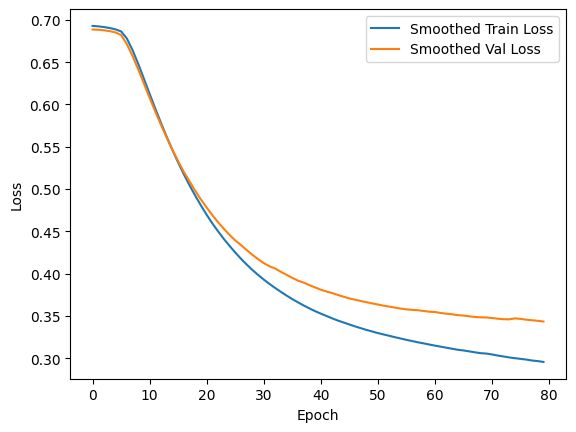

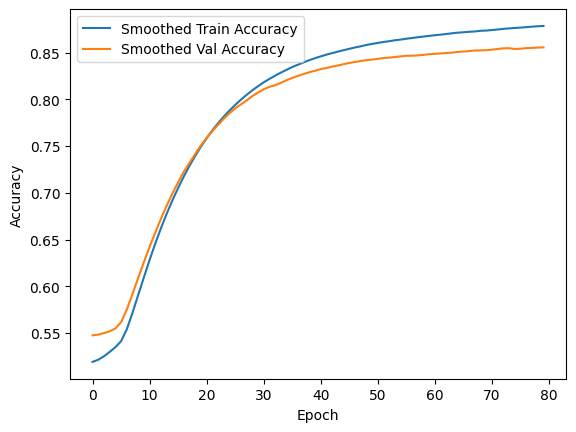

Test Accuracy: 0.8532


In [68]:
### Smoothing out the above graph
import numpy as np
import matplotlib.pyplot as plt

# Define a function for smoothing the data
def smooth_data(data, smoothing_factor=0.9):
    smoothed_data = []
    last_smoothed_point = data[0]
    for point in data:
        smoothed_point = last_smoothed_point * smoothing_factor + point * (1 - smoothing_factor)
        smoothed_data.append(smoothed_point)
        last_smoothed_point = smoothed_point
    return smoothed_data

# Smooth the train and validation losses
smoothed_train_losses = smooth_data(train_losses)
smoothed_val_losses = smooth_data(val_losses)

# Smooth the train and validation accuracies
smoothed_train_accuracies = smooth_data(train_accuracies)
smoothed_val_accuracies = smooth_data(val_accuracies)

# Plotting smoothed train and validation losses
plt.plot(smoothed_train_losses, label='Smoothed Train Loss')
plt.plot(smoothed_val_losses, label='Smoothed Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting smoothed train and validation accuracies
plt.plot(smoothed_train_accuracies, label='Smoothed Train Accuracy')
plt.plot(smoothed_val_accuracies, label='Smoothed Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## ** EXPERIMENTS **

## L2 Regularization with weight decay of 5e-3

Epoch 1/100, Time: 0.68s, Train Loss: 0.6943, Val Loss: 0.6895, Train Accuracy: 0.5122, Val Accuracy: 0.5400
Epoch 2/100, Time: 0.62s, Train Loss: 0.6896, Val Loss: 0.6856, Train Accuracy: 0.5344, Val Accuracy: 0.5567
Epoch 3/100, Time: 0.62s, Train Loss: 0.6860, Val Loss: 0.6826, Train Accuracy: 0.5489, Val Accuracy: 0.5707
Epoch 4/100, Time: 0.62s, Train Loss: 0.6832, Val Loss: 0.6803, Train Accuracy: 0.5600, Val Accuracy: 0.5780
Epoch 5/100, Time: 0.64s, Train Loss: 0.6808, Val Loss: 0.6782, Train Accuracy: 0.5672, Val Accuracy: 0.5775
Epoch 6/100, Time: 0.90s, Train Loss: 0.6788, Val Loss: 0.6763, Train Accuracy: 0.5713, Val Accuracy: 0.5800
Epoch 7/100, Time: 0.64s, Train Loss: 0.6768, Val Loss: 0.6746, Train Accuracy: 0.5747, Val Accuracy: 0.5820
Epoch 8/100, Time: 0.64s, Train Loss: 0.6750, Val Loss: 0.6730, Train Accuracy: 0.5782, Val Accuracy: 0.5845
Epoch 9/100, Time: 0.63s, Train Loss: 0.6733, Val Loss: 0.6714, Train Accuracy: 0.5814, Val Accuracy: 0.5870
Epoch 10/100, Time:

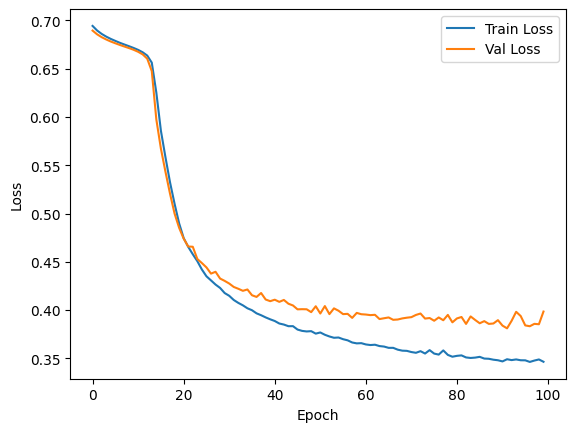

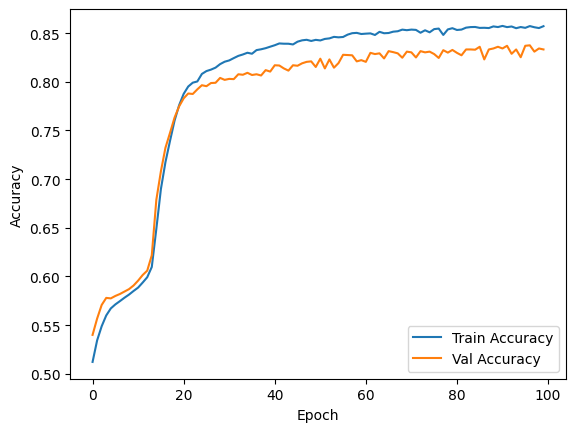

Test Accuracy: 0.8346


In [20]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
weight_decay = 5e-3  # Weight decay parameter
num_epochs = 100

# Instantiate the model and move it to GPU
model = GRU(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Adding weight decay

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

## L2 Regularization with weight decay of 6e-3

Epoch 1/100, Time: 0.67s, Train Loss: 0.6954, Val Loss: 0.6924, Train Accuracy: 0.5058, Val Accuracy: 0.5218
Epoch 2/100, Time: 0.63s, Train Loss: 0.6908, Val Loss: 0.6890, Train Accuracy: 0.5293, Val Accuracy: 0.5415
Epoch 3/100, Time: 0.63s, Train Loss: 0.6877, Val Loss: 0.6864, Train Accuracy: 0.5467, Val Accuracy: 0.5540
Epoch 4/100, Time: 0.64s, Train Loss: 0.6853, Val Loss: 0.6845, Train Accuracy: 0.5584, Val Accuracy: 0.5637
Epoch 5/100, Time: 0.63s, Train Loss: 0.6833, Val Loss: 0.6826, Train Accuracy: 0.5663, Val Accuracy: 0.5710
Epoch 6/100, Time: 0.63s, Train Loss: 0.6815, Val Loss: 0.6811, Train Accuracy: 0.5689, Val Accuracy: 0.5730
Epoch 7/100, Time: 0.63s, Train Loss: 0.6799, Val Loss: 0.6795, Train Accuracy: 0.5739, Val Accuracy: 0.5730
Epoch 8/100, Time: 0.63s, Train Loss: 0.6784, Val Loss: 0.6782, Train Accuracy: 0.5767, Val Accuracy: 0.5753
Epoch 9/100, Time: 0.63s, Train Loss: 0.6769, Val Loss: 0.6768, Train Accuracy: 0.5803, Val Accuracy: 0.5793
Epoch 10/100, Time:

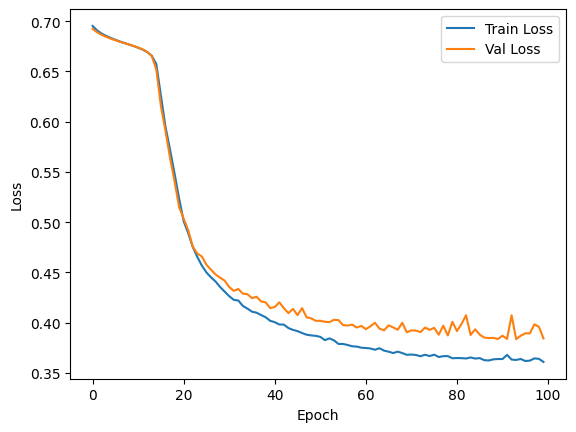

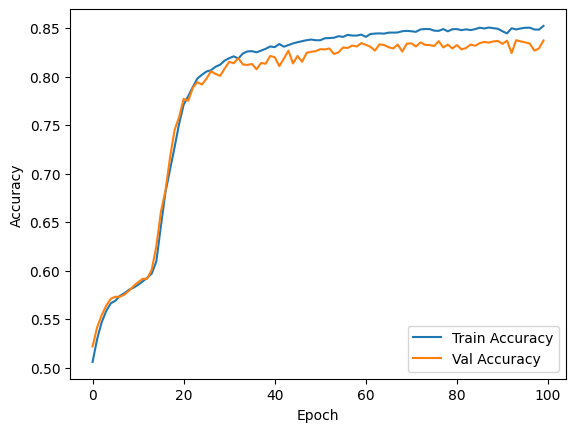

Test Accuracy: 0.8330


In [22]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
weight_decay = 6e-3  # Weight decay parameter
num_epochs = 100

# Instantiate the model and move it to GPU
model = GRU(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Adding weight decay

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')

____

___

## L2 Regularization with weight decay of 7e-3

Epoch 1/100, Time: 0.68s, Train Loss: 0.6948, Val Loss: 0.6930, Train Accuracy: 0.5083, Val Accuracy: 0.5175
Epoch 2/100, Time: 0.63s, Train Loss: 0.6916, Val Loss: 0.6901, Train Accuracy: 0.5245, Val Accuracy: 0.5248
Epoch 3/100, Time: 0.63s, Train Loss: 0.6892, Val Loss: 0.6879, Train Accuracy: 0.5398, Val Accuracy: 0.5400
Epoch 4/100, Time: 0.64s, Train Loss: 0.6873, Val Loss: 0.6861, Train Accuracy: 0.5486, Val Accuracy: 0.5485
Epoch 5/100, Time: 0.87s, Train Loss: 0.6857, Val Loss: 0.6846, Train Accuracy: 0.5544, Val Accuracy: 0.5505
Epoch 6/100, Time: 0.67s, Train Loss: 0.6843, Val Loss: 0.6831, Train Accuracy: 0.5591, Val Accuracy: 0.5600
Epoch 7/100, Time: 0.64s, Train Loss: 0.6832, Val Loss: 0.6820, Train Accuracy: 0.5629, Val Accuracy: 0.5640
Epoch 8/100, Time: 0.64s, Train Loss: 0.6821, Val Loss: 0.6810, Train Accuracy: 0.5660, Val Accuracy: 0.5680
Epoch 9/100, Time: 0.64s, Train Loss: 0.6811, Val Loss: 0.6801, Train Accuracy: 0.5666, Val Accuracy: 0.5685
Epoch 10/100, Time:

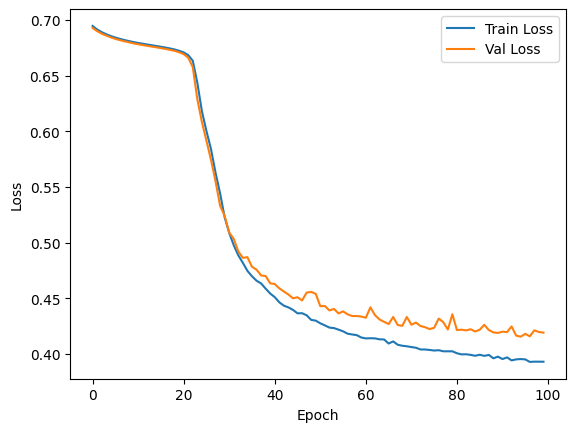

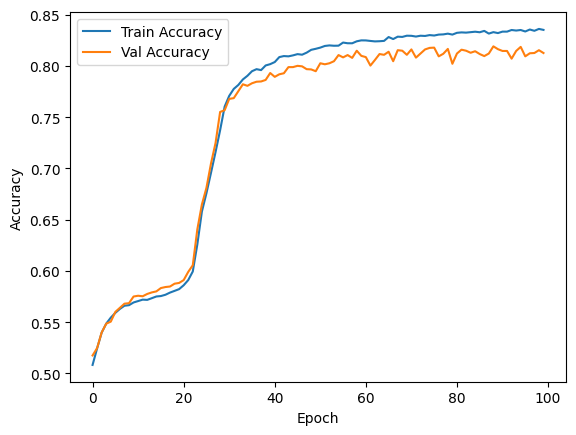

Test Accuracy: 0.8178


In [24]:
# Convert data to PyTorch tensors and move to GPU
x_train_tensor = torch.tensor(x_train).long().to(device)
y_train_tensor = torch.tensor(y_train.values).float().to(device)
x_val_tensor = torch.tensor(x_val).long().to(device)
y_val_tensor = torch.tensor(y_val.values).float().to(device)
x_test_tensor = torch.tensor(x_test).long().to(device)

# Create DataLoader for training and validation sets
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=512, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=512)

# Hyperparameters
embedding_dim = 64
hidden_dim = 64
learning_rate = 0.0001
weight_decay = 7e-3  # Weight decay parameter
num_epochs = 100

# Instantiate the model and move it to GPU
model = GRU(vocab_size=frequentWord, embedding_dim=embedding_dim, hidden_dim=hidden_dim).to(device)

# Define loss function and optimizer
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)  # Adding weight decay

# Training loop
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

for epoch in range(num_epochs):
    start_time = time.time()  # Record start time for the epoch

    model.train()
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)

        predicted = torch.round(outputs)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accuracy = correct_train / total_train
    train_accuracies.append(train_accuracy)

    model.eval()
    val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move batch to GPU
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)

            predicted = torch.round(outputs)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    val_accuracy = correct_val / total_val
    val_accuracies.append(val_accuracy)

    epoch_time = time.time() - start_time  # Calculate time taken for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Time: {epoch_time:.2f}s, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}')

# Plotting train and validation losses
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting train and validation accuracies
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluation on test set
model.eval()
with torch.no_grad():
    outputs = model(x_test_tensor)
    y_pred = torch.round(outputs).cpu().numpy()  # Move predictions to CPU for numpy conversion

# Calculate test accuracy
test_accuracy = np.mean(y_pred == y_test.values)
print(f'Test Accuracy: {test_accuracy:.4f}')